## Genz Function Approximation with PCE fitted via BCS

In this example, we approximate the Genz Oscillatory function by constructing a Polynomial Chaos (PC) surrogate with Bayesian compressive sensing (BCS). The first build process uses a given eta of 1e-10, while the second build process selects the most optimal eta for BCS through cross-validation. Both models are then evaluated on testing and training data, returning parity plots and a Root Mean Square Error for each evaluation. 

To follow along with the cross-validation algorithm used to select the optimal eta, see section "Functions for cross-validation algorithm" at the end of the notebook.

In [1]:
import os
import sys

import numpy as np
import copy
import math
import pytuq.utils.funcbank as fcb
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error


from pytuq.surrogates.pce import PCE
from pytuq.utils.maps import scale01ToDom
from pytuq.func.genz import GenzOscillatory

Setting a random number generator seed:

In [2]:
# Random number generator
from scipy.stats import qmc
rng_seed = 43

# Constructing PC surrogate and generating data

We generate the Genz function, as well as training data and testing data with output noise. This data and the corresponding Genz function will be used to create the same PC surrogate fitted in both examples: (1) The first surrogate will be fitted using BCS with a given eta, and (2) the second surrogate will be fitted using BCS with the most optimal eta.

In [21]:
# Use Genz Oscillatory function in multiple dimensions for the true model
func_dim = 4
func_weights = [1.0/(i+1)**2 for i in range(func_dim)]
func = GenzOscillatory(shift=0.25, weights=func_weights)
noise_std = 0.1
rng = qmc.LatinHypercube(d=func_dim, seed=rng_seed)

# Training data
np.random.seed(42)
n_trn = 70
x_trn = rng.random(n=n_trn) # random numbers in [0,1]^d
y_trn = func(x_trn) + np.random.normal(0, noise_std, size = (n_trn,1))

# Testing data
n_tst = 10000
x_tst = rng.random(n=n_tst) # random numbers in [0,1]^d
y_tst = func(x_tst) + np.random.normal(0, noise_std, size = (n_tst,1))

With a stochastic dimensionality of 4 (defined above) and a polynomial order of 4, we construct the PC surrogate that will be used in both builds. You have the option of printing the PC surrogate's full basis, before BCS selects and retains the most significant PC coefficients to reduce the basis.

In [22]:
# (1) Construct a PC surrogate
order = 4
pce_surr = PCE(func_dim, order, 'LU', verbose = 1)

# Optional verbosity output:
print("Full Basis and Current Coefficients:")
pce_surr.pcrv.printInfo()
print("Number of Basis Terms:", len(pce_surr.pcrv.mindices[0]))

# (1.5) Set training data
pce_surr.set_training_data(x_trn, y_trn[:,0])

Constructed PC Surrogate with the following attributes:
['LU', 'LU', 'LU', 'LU'] PC Random Variable(pdim=1, sdim=4)

Full Basis and Current Coefficients:
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [2 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [0 2 0 0]
 [0 1 1 0]
 [0 1 0 1]
 [0 0 2 0]
 [0 0 1 1]
 [0 0 0 2]
 [3 0 0 0]
 [2 1 0 0]
 [2 0 1 0]
 [2 0 0 1]
 [1 2 0 0]
 [1 1 1 0]
 [1 1 0 1]
 [1 0 2 0]
 [1 0 1 1]
 [1 0 0 2]
 [0 3 0 0]
 [0 2 1 0]
 [0 2 0 1]
 [0 1 2 0]
 [0 1 1 1]
 [0 1 0 2]
 [0 0 3 0]
 [0 0 2 1]
 [0 0 1 2]
 [0 0 0 3]
 [4 0 0 0]
 [3 1 0 0]
 [3 0 1 0]
 [3 0 0 1]
 [2 2 0 0]
 [2 1 1 0]
 [2 1 0 1]
 [2 0 2 0]
 [2 0 1 1]
 [2 0 0 2]
 [1 3 0 0]
 [1 2 1 0]
 [1 2 0 1]
 [1 1 2 0]
 [1 1 1 1]
 [1 1 0 2]
 [1 0 3 0]
 [1 0 2 1]
 [1 0 1 2]
 [1 0 0 3]
 [0 4 0 0]
 [0 3 1 0]
 [0 3 0 1]
 [0 2 2 0]
 [0 2 1 1]
 [0 2 0 2]
 [0 1 3 0]
 [0 1 2 1]
 [0 1 1 2]
 [0 1 0 3]
 [0 0 4 0]
 [0 0 3 1]
 [0 0 2 2]
 [0 0 1 3]
 [0 0 0 4]] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0

# BCS with default settings (default eta)

Here, we call the PCE class method of `build()` to build the linear regression model used to fit the surrogate. With the flag `regression='bcs'`, we choose the BCS method for the fitting. A user-defined eta of 1e-10 is also passed in.

In [23]:
# (2) Build the linear regression object for fitting
pce_surr.build(regression='bcs', eta=1.e-10)

# Optional verbosity output:
print("Retained Basis and Coefficients:")
pce_surr.pcrv.printInfo()
print("Number of retained basis terms:", len(pce_surr.pcrv.mindices[0]))

Regression method: bcs
Retained Basis and Coefficients:
[[2 0 0 0]
 [1 0 3 0]
 [0 2 0 2]
 [0 0 1 2]
 [4 0 0 0]
 [3 1 0 0]
 [1 1 0 1]
 [2 0 0 2]
 [2 0 1 1]
 [0 0 0 4]
 [1 0 0 3]
 [0 0 0 1]
 [1 1 0 0]
 [1 0 0 1]
 [0 3 1 0]
 [0 1 0 2]
 [0 1 1 2]
 [2 0 2 0]
 [0 1 0 1]
 [0 0 0 0]] [ 0.11844696 -0.1286659  -0.23890894  0.20561299 -0.65563148  1.41773821
 -0.20218904 -0.30625401  0.40503892 -0.27250245  0.99544673 -0.90463019
 -2.75925351 -0.66386396  0.13068211 -0.96868699 -0.65718534 -0.27253516
  3.07988105  0.12550357]
Number of retained basis terms: 20


After fitting, we evaluate the PCE using our training and testing data. To analyze the model's goodness of fit, we calculate the root mean square error between the surrogate results and the training and testing data.

In [24]:
# (3) Evaluate the PC model
y_trn_approx = pce_surr.evaluate(x_trn)
y_tst_approx = pce_surr.evaluate(x_tst)

# Evaluate goodness of fit with RMSE
rmse_trn = root_mean_squared_error(y_trn[:,0],y_trn_approx["Y_eval"])
print("The training RMSE error in the PCE BCS approximation is %.2e"%rmse_trn)

rmse_tst = root_mean_squared_error(y_tst[:,0],y_tst_approx["Y_eval"])
print("The testing RMSE error in the PCE BCS approximation is %.2e"%rmse_tst)

The training RMSE error in the PCE BCS approximation is 1.72e-01
The testing RMSE error in the PCE BCS approximation is 2.73e-01


Notice above how the training RMSE error is almost half that of the testing RMSE error. This shows that our current model is overfitting, learning the training data with noise too well. To address this issue, we can explore selecting a better eta for the BCS fitting.

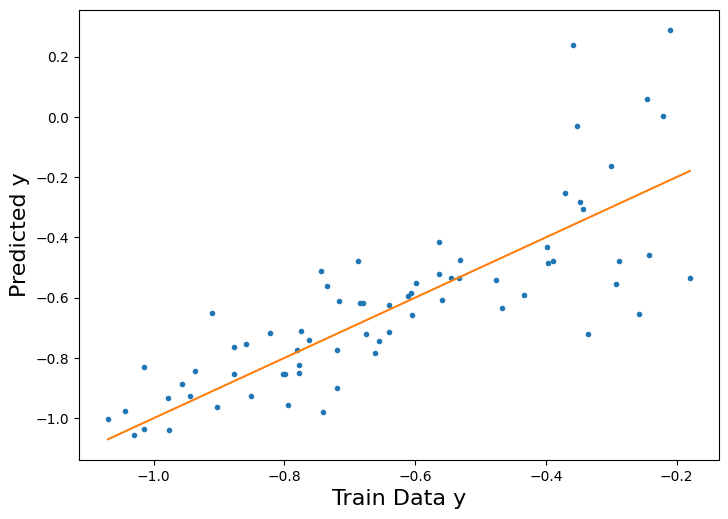

In [25]:
# Plot the surrogate model's output vs. the training data output

y_trn_mM = [y_trn[:,0].min(),y_trn[:,0].max()]


fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_axes([0.15, 0.15, 0.80, 0.75])


ax1.plot(y_trn[:,0],y_trn_approx["Y_eval"],".")
ax1.plot(y_trn_mM,y_trn_mM) # Diagonal line

ax1.set_xlabel("Train Data y", size=16)
ax1.set_ylabel("Predicted y", size=16); 

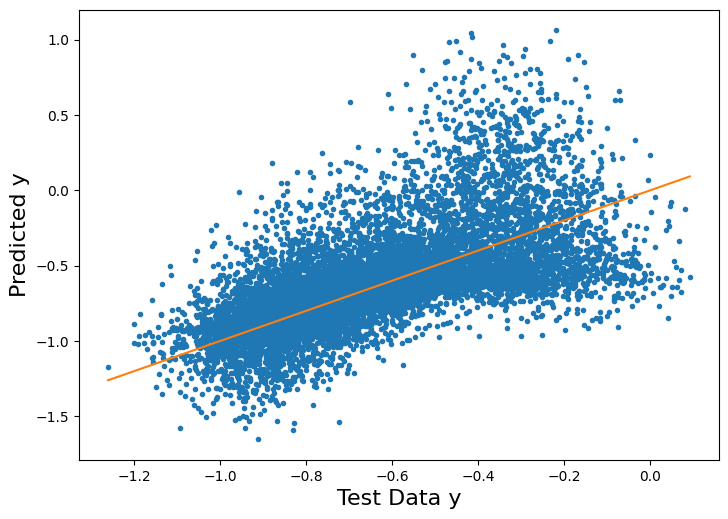

In [13]:
# Plot the surrogate model's output vs. the testing data output

y_tst_mM = [y_tst[:,0].min(),y_tst[:,0].max()]


fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_axes([0.15, 0.15, 0.80, 0.75])


ax2.plot(y_tst[:,0],y_tst_approx["Y_eval"],".")
ax2.plot(y_tst_mM,y_tst_mM) # Diagonal line

ax2.set_xlabel("Test Data y", size=16)
ax2.set_ylabel("Predicted y", size=16); 

# BCS with optimal eta (found through cross-validation) 

In this section, we use the same PC surrogate, `pce_surr`, for the second build. We call the PCE class method of `build()` to build the linear regression model used to fit the surrogate. With the flag `regression='bcs'`, we choose the BCS method for the fitting. 

Instead of using a default eta, we call the cross-validation algorithm, `optimize_eta()`, to choose the most optimal eta below. 
- With the flag `plot=True`, the CV algorithm produces a graph of the training and testing (validation) data's RMSE values for each eta. The eta with the smallest RMSE for the validation data is the one chosen as the optimal eta.

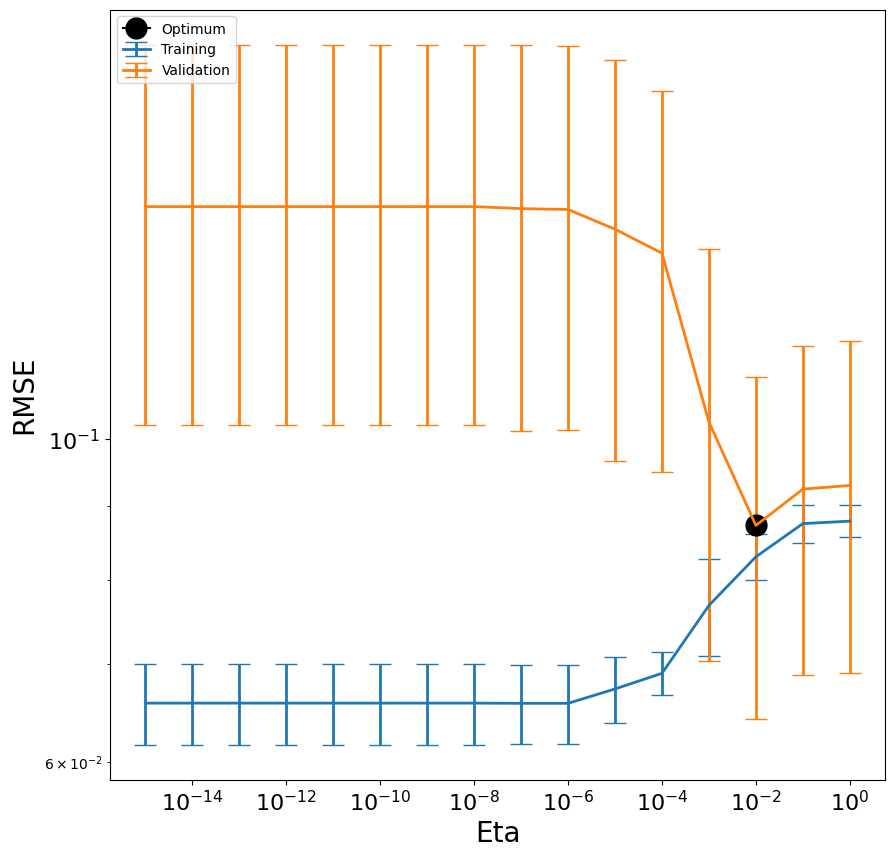

In [29]:
# We first create a list of possible etas to pass in: [1e-16, 1e-15, ... , 1e-2, 1e-1, 1]
etas = 1/np.power(10,[i for i in range(0,16)])

# Then, we call the function to choose the optimal eta:
eta_opt = optimize_eta(pce_surr, etas, 10, plot=True)

Now, with the optimal eta obtained, we run the fitting again. Then, we evaluate the PCE and produce a parity plot for the predicted output vs. the testing data. Notice that the larger eta, 10e-2, retained fewer basis terms (6) compared to the smaller user-defined eta of 10e-10 (which retained 20 basis terms).

In [30]:
# Build the linear regression object for fitting
pce_surr.build(regression='bcs', eta=eta_opt)

# Optional verbosity output:
print("Retained Basis and Coefficients:")
pce_surr.pcrv.printInfo()
print("Number of retained basis terms:", len(pce_surr.pcrv.mindices[0]))

Regression method: bcs
Retained Basis and Coefficients:
[[1 0 0 0]
 [2 0 0 0]
 [0 1 0 1]
 [1 0 3 0]
 [0 2 0 2]
 [0 0 1 2]] [-1.15692903  0.24292952 -0.29524043 -0.15503765  0.13276008  0.06118484]
Number of retained basis terms: 6


In [31]:
# Evaluate the PC model with training and testing data
y_trn_approx = pce_surr.evaluate(x_trn)
y_tst_approx = pce_surr.evaluate(x_tst)

# Evaluate goodness of fit with RMSE
rmse_trn = root_mean_squared_error(y_trn[:,0],y_trn_approx["Y_eval"])
print("The training RMSE error in the PCE BCS approximation is %.2e"%rmse_trn)

rmse_tst = root_mean_squared_error(y_tst[:,0],y_tst_approx["Y_eval"])
print("The testing RMSE error in the PCE BCS approximation is %.2e"%rmse_tst)

The training RMSE error in the PCE BCS approximation is 8.11e-02
The testing RMSE error in the PCE BCS approximation is 1.10e-01


While the training RMSE error was almost half that of the testing RMSE error for the first fitting, the RMSE errors here are much closer to each other in value. This suggests that the model has more effectively generalized to the unseen data; a better eta has improved performance.

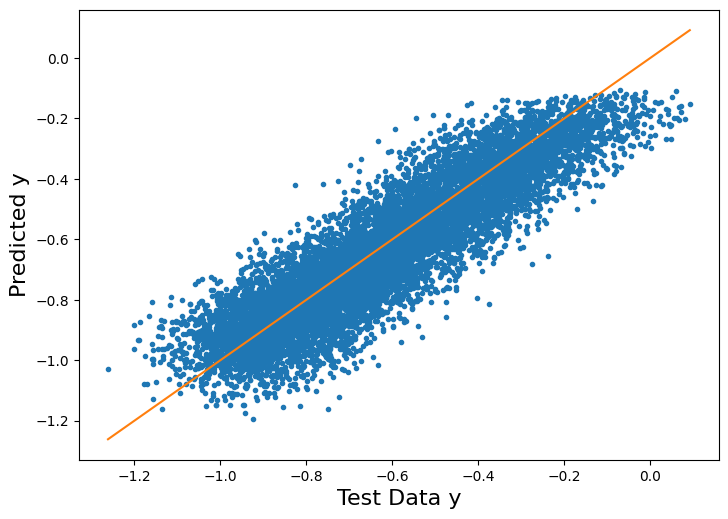

In [32]:
# Plot the surrogate model's output vs. the testing data output
y_tst_mM = [y_tst[:,0].min(),y_tst[:,0].max()]


fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_axes([0.15, 0.15, 0.80, 0.75])


ax2.plot(y_tst[:,0],y_tst_approx["Y_eval"],".")
ax2.plot(y_tst_mM,y_tst_mM) # Diagonal line

ax2.set_xlabel("Test Data y", size=16)
ax2.set_ylabel("Predicted y", size=16); 

# Functions for cross-validation algorithm

Below, we expose the cross-validation algorithm `optimize_eta` and its two helper functions, `kfold_split` and `kfold_cv`.

In [9]:
def kfold_split(nsamples,nfolds,seed=13):
    """
    Return dictionary of training and testing pairs using k-fold cross-validation.

    Args:
        nsamples (int): Total number of training samples.
        nfolds (int): Number of folds to use for k-fold cross-validation.
        seed (int, optional): Random seed for reproducibility. Defaults to 13.

    Returns:
        dict: A dictionary where each key is the fold number (0 to nfolds-1) 
        and each value is a dictionary with:
            - "train index" (np.ndarray): Indices of training samples.
            - "val index" (np.ndarray): Indices of validation samples.
    """
    # Returns split data where each data is one fold left out
    KK=nfolds
    rn = np.random.RandomState(seed)

    # Creating a random permutation of the samples indices list
    indp=rn.permutation(nsamples)

    # Split the permuted indices into KK (or # folds) equal-sized chunks 
    split_index=np.array_split(indp,KK)

    # Dictionary to hold the indices of the training and validation samples
    cvindices = {}

    # create testing and training folds
    for j in range(KK):
        # Iterating through the number of folds
        fold = j
        # Iterate through # folds, if i != fold number, 
        newindex = [split_index[i] for i in range(len(split_index)) if i != (fold)]
        train_ind = np.array([],dtype='int64')
        for i in range(len(newindex)): train_ind = np.concatenate((train_ind,newindex[i]))
        test_ind = split_index[fold]
        cvindices[j] = {'train index': train_ind, 'val index': test_ind}

    return cvindices

In [10]:
def kfold_cv(x,y,nfolds=3,seed=13):
    """
    Splits data into training/testing pairs for kfold cross-val
    x is a data matrix of size n x d1, d1 is dim of input
    y is a data matrix of size n x d2, d2 is dim of output

    Args:
    x (np.ndarray): 
        Input matrix with shape (n, d1) or 1D array with shape (n,).
        Each row is a sample; columns are input features.
    y (np.ndarray):
        Target array with shape (n,) for single-output, or (n, d2) for
        multi-output. If 1D, it is internally reshaped to (n, 1) before
        slicing; outputs are `np.squeeze`d per fold.
    nfolds (int, optional): Number of folds for cross-validation. Defaults to 3.
    seed (int, optional):
        Random seed for reproducible shuffling in `kfold_split`. Defaults to 13.
    """
    if len(x.shape)>1:
        n,d1 = x.shape
    else:
        n=x.shape
    ynew = np.atleast_2d(y)
    if len(ynew) == 1: ynew = ynew.T # change to shape (n,1)
    _,d2 = ynew.shape
    cv_idx = kfold_split(n,nfolds,seed)

    kfold_data = {}
    for k in cv_idx.keys():
        kfold_data[k] = {
        'xtrain': x[cv_idx[k]['train index']],
        'xval': x[cv_idx[k]['val index']],
        'ytrain': np.squeeze(ynew[cv_idx[k]['train index']]),
        'yval': np.squeeze(ynew[cv_idx[k]['val index']])
        } # use squeeze to return 1d array

        # set train and test to the same if 1 fold
        if nfolds == 1:
            kfold_data[k]['xtrain'] = kfold_data[k]['xval']
            kfold_data[k]['ytrain'] = kfold_data[k]['yval']

    return kfold_data

In [11]:
def optimize_eta(pce, etas, nfolds, verbose=0, plot=False):
    """
    Choose the optimum eta for Bayesian compressive sensing. Calculates the RMSE
        for each eta for a specified number of folds. Selects the eta with the lowest
        RMSE after averaging the RMSEs over the folds.

    Input:
        y:             1D numpy array (vector) with function, evaluated at the
                            sample points [#samples,]
        x:             N-dimensional NumPy array with sample points [#samples,
                            #dimensions]
        etas:          NumPy array or list with the threshold for stopping the
                            algorithm. Smaller values retain more nonzero
                            coefficients
        verbose:       Flag for print statements
        plot:          Flag for whether to generate a plot for eta optimization

    Output:
        eta_opt:      Optimum eta

    """
    # Split data in k folds -> Get dictionary of data split in training + testing folds
    kfold_data = kfold_cv(pce._x_train, pce._y_train, nfolds)

    # Each value has data for 1 fold. Each value is a list of the RMSEs for each possible eta in the fold. 
    RMSE_list_per_fold_tr = [] 

    # Same but for testing data
    RMSE_list_per_fold_test = []

    # Make a copy of the PCE object to run the cross-validation algorithm on
    pce_copy = copy.deepcopy(pce)
    pce_copy.verbose = 0

    # Loop through each fold
    for i in range(nfolds):

        # Get the training and validation data
        x_tr = kfold_data[i]['xtrain']
        y_tr = kfold_data[i]['ytrain']
        x_test = kfold_data[i]['xval']
        y_test = kfold_data[i]['yval']
        
        # As we conduct BCS for this fold with each separate eta, the RMSEs will be added to these lists
        RMSE_per_eta_tr = [] 
        RMSE_per_eta_test = [] 

        # Set the x and y training data for the copied PCE object
        pce_copy.set_training_data(x_tr, y_tr)

        # Loop through each eta
        for eta in etas:

            # Conduct the BCS fitting. The object is automatically updated with new multiindex and coefficients received from the fitting.
            cfs = pce_copy.build(regression = 'bcs', eta=eta)

            # Evaluate the PCE object at the training and validation points 
            y_tr_eval = (pce_copy.evaluate(x_tr))['Y_eval']
            y_test_eval = (pce_copy.evaluate(x_test))['Y_eval']

            # Print statement for verbose flag
            if verbose > 1:
                print("Fold " + str(i + 1) + ", eta " + str(eta) + ", " + str(len(cfs)) + " terms retained out of a full basis of size " + str(len(pce.pcrv.mindices[0])))
            
            # Calculate the RMSEs for the training and validation points.
            # Append the values into the list of etas per fold.
            MSE = np.square(np.subtract(y_tr, y_tr_eval)).mean()
            RMSE = math.sqrt(MSE)
            RMSE_per_eta_tr.append(RMSE)

            MSE = np.square(np.subtract(y_test, y_test_eval)).mean()
            RMSE = math.sqrt(MSE)
            RMSE_per_eta_test.append(RMSE)

        # Now, append the fold's list of RMSEs for each eta into the list carrying the lists for all folds 
        RMSE_list_per_fold_tr.append(RMSE_per_eta_tr)
        RMSE_list_per_fold_test.append(RMSE_per_eta_test)

    # After compiling the RMSE data for each eta from all the folds, we find the eta with the lowest validation RMSE to be our optimal eta.
    # Compute the average and standard deviation of the training and testing RMSEs over the folds
    avg_RMSE_tr = np.array(RMSE_list_per_fold_tr).mean(axis=0)
    avg_RMSE_test = np.array(RMSE_list_per_fold_test).mean(axis=0)

    std_RMSE_tr = np.std(np.array(RMSE_list_per_fold_tr), axis=0)
    std_RMSE_test = np.std(np.array(RMSE_list_per_fold_test), axis=0)

    # Choose the eta with lowest RMSE across all folds' testing data
    eta_opt = etas[np.argmin(avg_RMSE_test)]

    # Plot RMSE vs. eta for training and testing RMSE
    if plot:

        fig, ax = plt.subplots(figsize=(10,10))

        plt.errorbar(etas, avg_RMSE_tr, xerr=None, yerr=std_RMSE_tr, linewidth=2, markersize=8, capsize=8, label=('Training'))
        plt.errorbar(etas, avg_RMSE_test, xerr=None, yerr=std_RMSE_test, linewidth=2, markersize=8, capsize=8, label=('Validation'))

        plt.plot(eta_opt, np.min(avg_RMSE_test), marker="o", markersize=15, color='black', label=("Optimum"))

        plt.xlabel("Eta",fontsize=20)
        plt.ylabel("RMSE",fontsize=20)

        # Change size of tick labels
        plt.tick_params(axis='both', labelsize=16)

        plt.xscale('log')
        plt.yscale('log')

        # Create legend
        plt.legend(loc='upper left')

        # Save
        plt.savefig('eta_opt.pdf', format='pdf', dpi=1200)

    return eta_opt